In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

In [65]:
import multiprocessing

In [66]:
rs=121
ns=5
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']
testing_size=500
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
spread_range = range(2, 25)

In [69]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output_kalman.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','HighR','LowR','Volatility']
data_features=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
#features=['Smooth_'+x for x in features]+['Volatility','Smooth_Volume']
target='State'

In [73]:
data[features]=data_features[features]

In [75]:
#With TimeSeries
#First Set Aside Testing data
final_test=[]
stocks_data=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    stocks_data.append(x[1][:-ft_size])

In [76]:
def create_sliding_window(train_df, test_df, features, target, window=7):
    splitter = SlidingWindowSplitter(window_length=window, step_length=1, fh=[1])
    train_x, train_y, test_x, test_y = [], [], [], []

    for idx in splitter.split(train_df):
        X = train_df.iloc[idx[0]][features].values.flatten()
        y = train_df.iloc[idx[1]][target].values.flatten()[0]
        train_x.append(X)
        train_y.append(y)

    for idx in splitter.split(test_df):
        X = test_df.iloc[idx[0]][features].values.flatten()
        y = test_df.iloc[idx[1]][target].values.flatten()[0]
        test_x.append(X)
        test_y.append(y)

    return (train_x, train_y), (test_x, test_y)

In [77]:
testing_size=500
ns=5
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
spread_range = range(2, 25)

In [78]:
training_lists = {}
testing_lists = {}
for spread in spread_range:
    training_lists[spread] = {}
    testing_lists[spread] = {}
    for ticker_idx, ticker_df in enumerate(stocks_data):
        ticker = list(ticker_df["Ticker"])[0]
        training_list = [[[], []] for _ in range(ns)]
        testing_list = [[[], []] for _ in range(ns)]
        for fold_idx, (train_idx, test_idx) in enumerate(tss.split(ticker_df)):
            train_df = ticker_df.iloc[train_idx]
            test_df = ticker_df.iloc[test_idx]           
            (train_x, train_y), (test_x, test_y) = create_sliding_window(train_df, test_df, features, target, window=spread)
            training_list[fold_idx][0] += train_x
            training_list[fold_idx][1] += train_y
            testing_list[fold_idx][0] += test_x
            testing_list[fold_idx][1] += test_y
        training_lists[spread][stocks.index(ticker)] = training_list
        testing_lists[spread][stocks.index(ticker)] = testing_list #spread->stock index->time series split->data/label

In [79]:
with open('saved_training_lists_kalman_unsmoothened.pkl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_lists_kalman_unsmoothened.pkl', 'wb') as f:
    pickle.dump(testing_lists, f)


In [ ]:
with open('saved_training_lists_kalman.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists_kalman.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [62]:
with open('saved_training_lists.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [80]:
def accuracies_model(model_dict, window, stock_ind, map=True):
    a=0
    conf_mat=np.zeros((2,2))
    y_true_all=[]
    y_pred_all=[]
    if map:
        model = model_dict[window][stock_ind]
    else:
        model = model_dict
    for i in range(ns):
        model.fit(X=training_lists[window][stock_ind][i][0],y=training_lists[window][stock_ind][i][1])
        y_pred=model.predict(testing_lists[window][stock_ind][i][0])
        y_true=testing_lists[window][stock_ind][i][1]
        a+= accuracy_score(y_true,y_pred)
        y_true_all=y_true_all+list(y_true)
        y_pred_all=y_pred_all+list(y_pred)
    conf_mat=confusion_matrix(y_true=y_true_all,y_pred=y_pred_all)
    a=a/ns
    return (a,conf_mat)

In [81]:
def plot_accuracies(accuracies, model_type, acc_type="accuracy"): #accuracies needs to be a nested dictionary window->stock index
    for stock_ind in range(len(stocks)):
        vals = []
        for window in accuracies.keys():
            vals.append(accuracies[window][stock_ind])
        plt.figure(figsize=(6, 4))
        plt.plot(list(accuracies.keys()), vals, marker='o')
        plt.title(f"{model_type} accuracy scores for {stocks[stock_ind]}")
        plt.xlabel("Window size")
        plt.ylabel(acc_type)
        plt.tight_layout()
        plt.show()

In [44]:
#Find best models
window=12
model=AdaBoostClassifier()
tree_depths=[DecisionTreeClassifier(max_depth=x) for x in range(6)]

parameters = {
    'n_estimators' : range(100,250,20),
    'learning_rate' : [0.5,0.7,0.9,1,1.1,1.3],
    'estimator' : tree_depths
}
grid_searches = [GridSearchCV(model, parameters, cv = 5, n_jobs=-1) for i in range(len(stocks))]
results=[]
for stock_ind in range(len(stocks)):
    grid_searches[stock_ind].fit(X=training_lists[window][stock_ind][-1][0],y=training_lists[window][stock_ind][-1][1])

/home/srijan/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
240 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/srijan/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/srijan/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sr

In [45]:
models_best=[x.best_estimator_ for x in grid_searches]

In [46]:
with open('ada_best_models.pkl', 'wb') as f:
    pickle.dump(models_best, f)

In [82]:
accuracies_ada = {}
confusion_mat = {}
f1_score={}
#ada_model = AdaBoostClassifier(n_estimators=100,random_state=121)
for window in spread_range:
    accuracies_ada[window] = {}
    confusion_mat[window] = {}
    f1_score[window]={}
    def helper(i):
        return accuracies_model(models_best[i],window,i,map=False)
    pool=multiprocessing.Pool(len(stocks))
    results=list(pool.map(helper, range(len(stocks))))
    for stock_ind in range(len(stocks)):
        accuracies_ada[window][stock_ind] = results[stock_ind][0]
        confusion_mat[window][stock_ind] = results[stock_ind][1]
        A=confusion_mat[window][stock_ind]
        f1_score[window][stock_ind]=(2*A[0][0]/(2*A[0][0]+A[0][1]+A[1][0]))
        


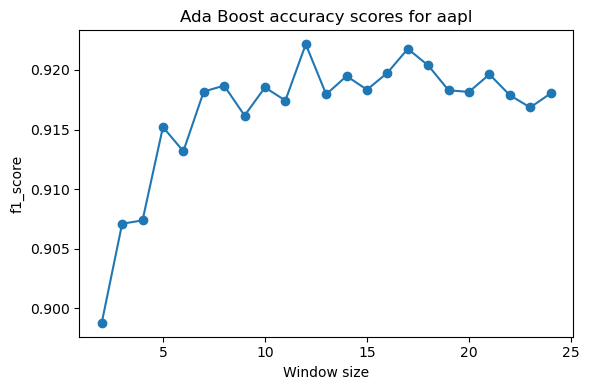

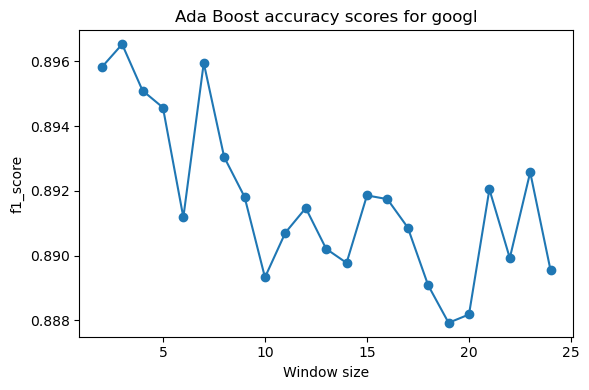

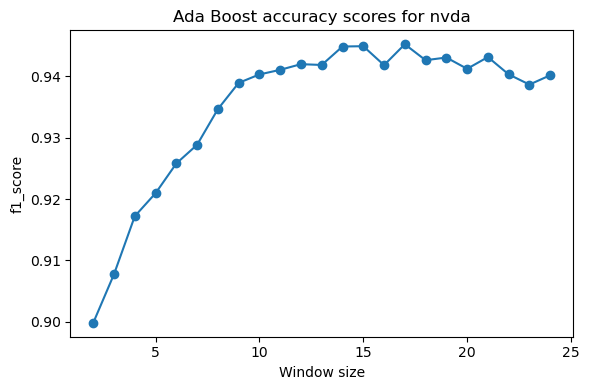

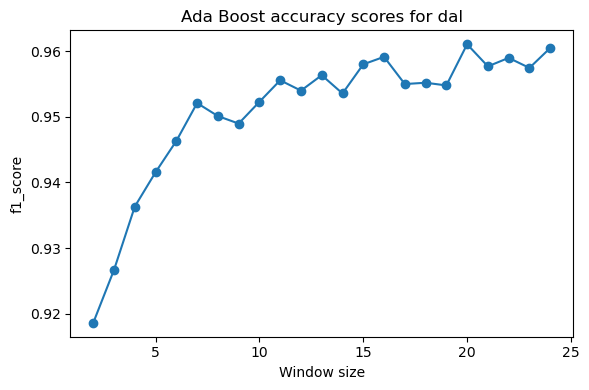

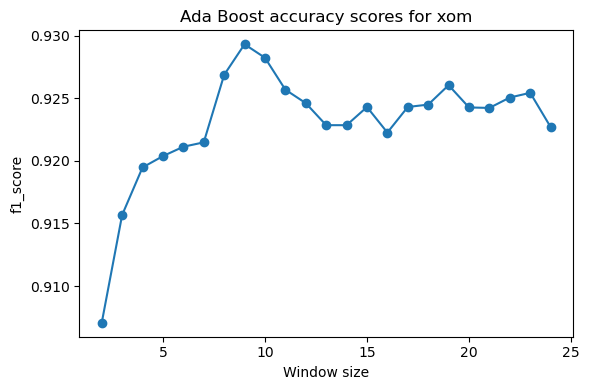

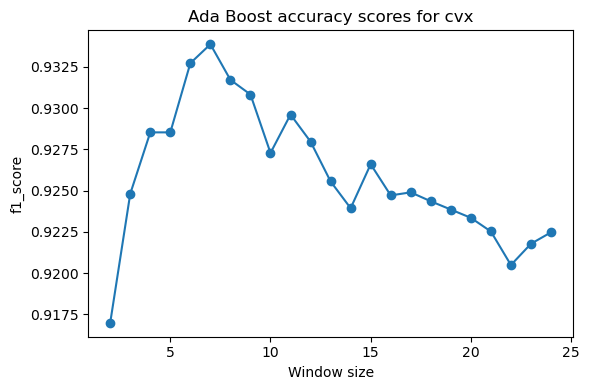

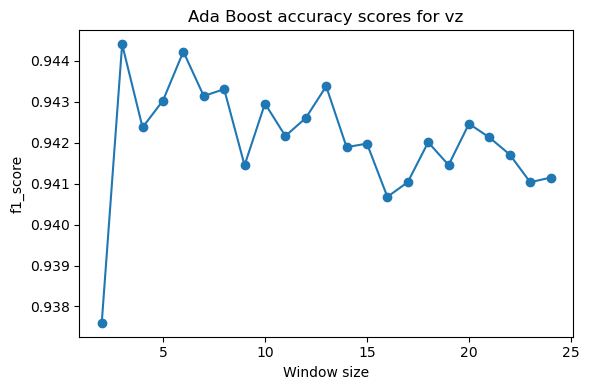

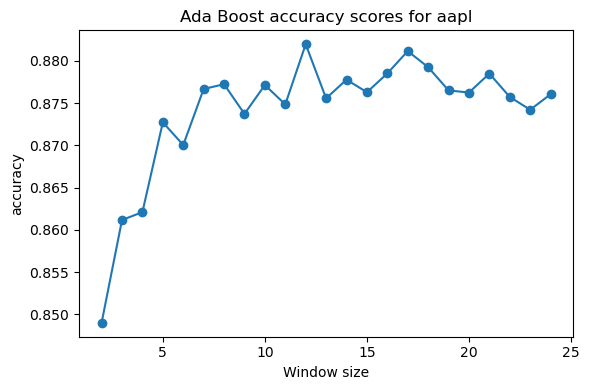

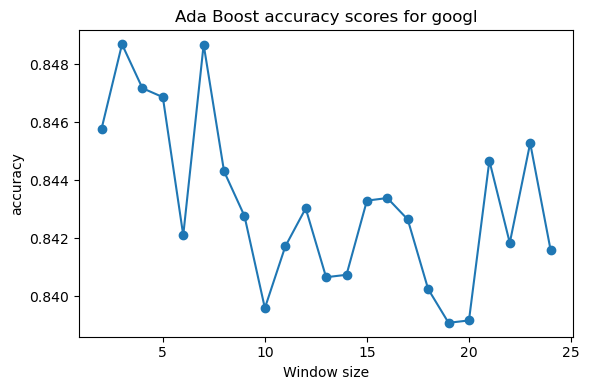

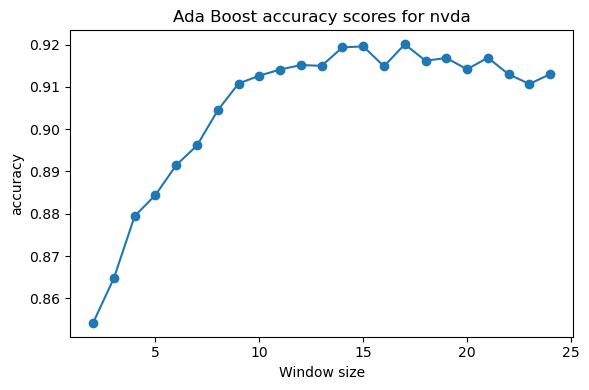

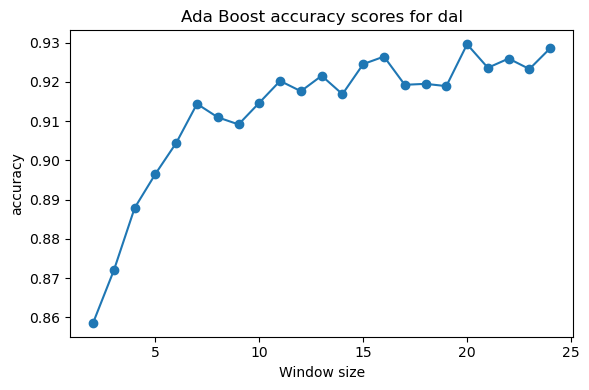

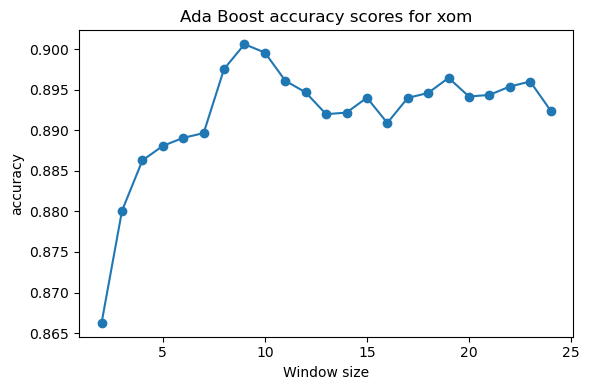

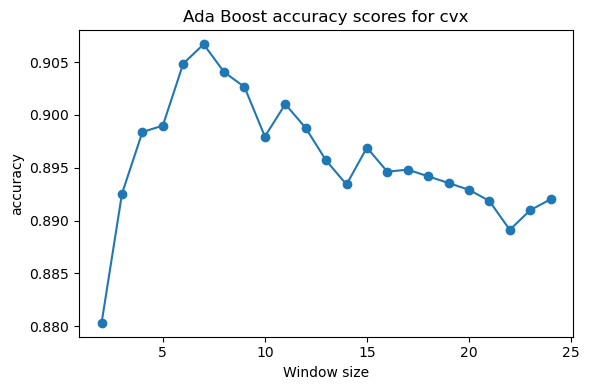

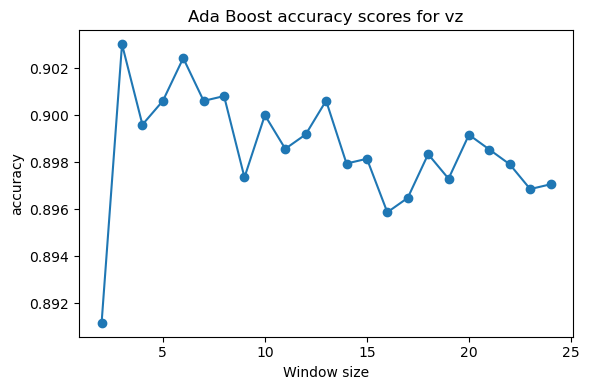

In [83]:
plot_accuracies(f1_score, "Ada Boost",acc_type="f1_score")
plot_accuracies(accuracies_ada, "Ada Boost")

In [90]:
model_forest = RandomForestClassifier(
    n_estimators = 100, # number of trees in ensemble
    max_depth = 10, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 5, # default is round(sqrt(num_features)), which in this case is 1.
    random_state = 121 # for consistency
    )

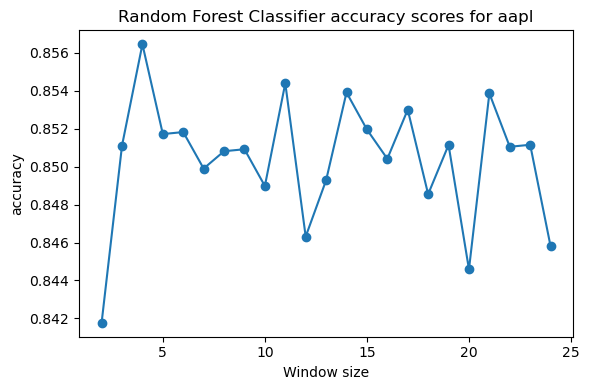

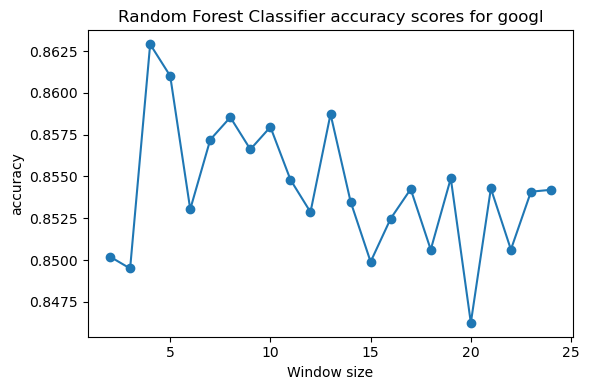

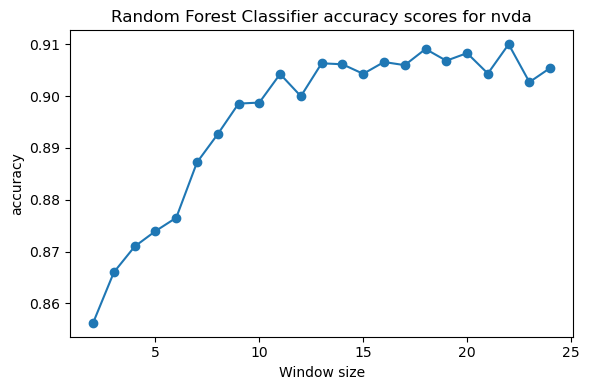

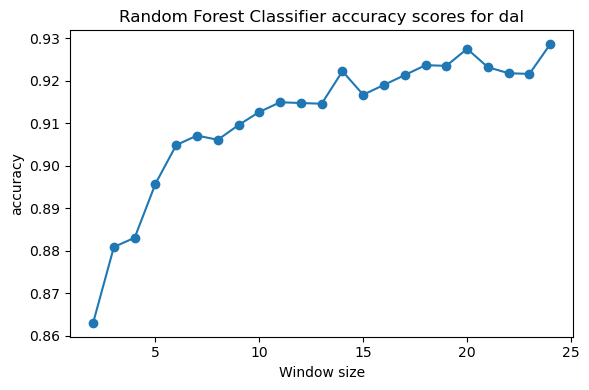

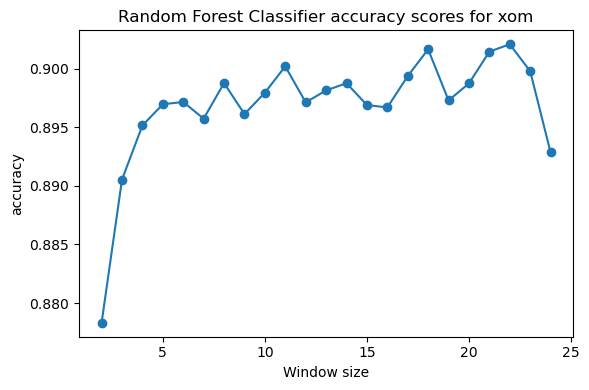

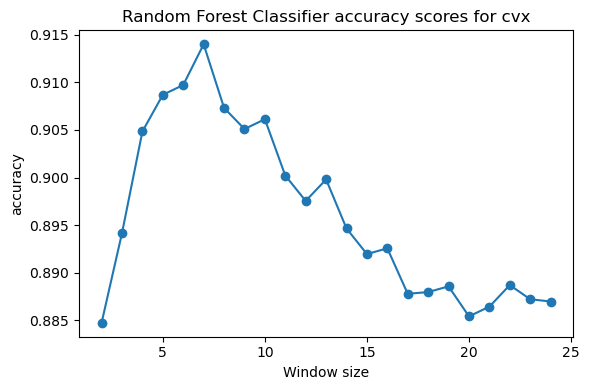

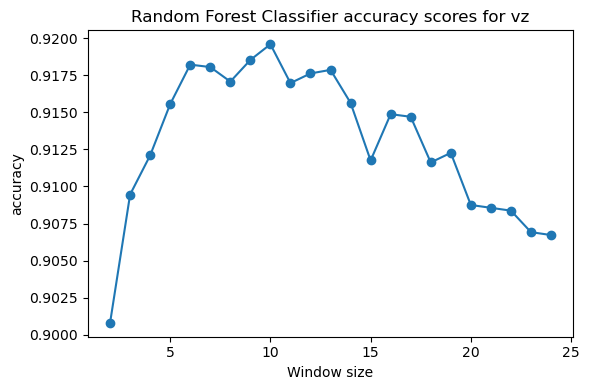

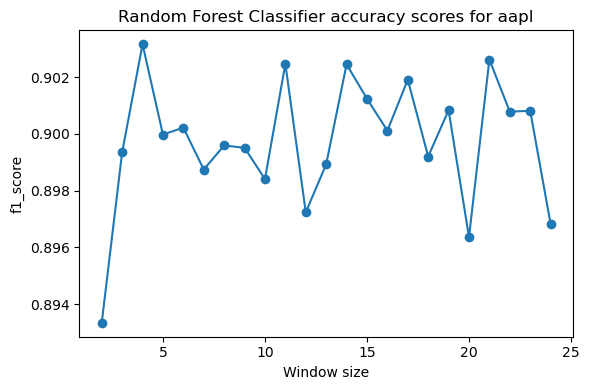

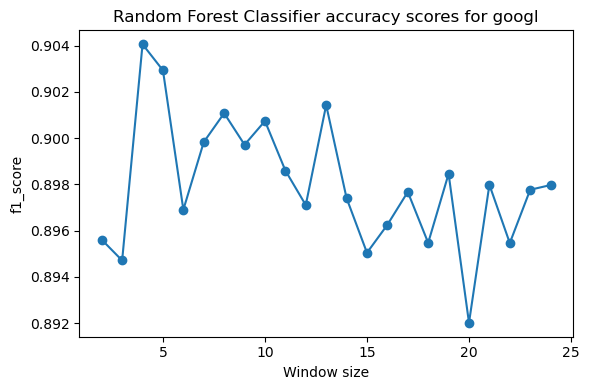

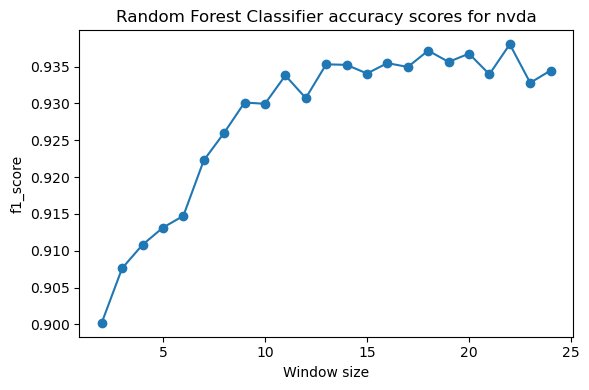

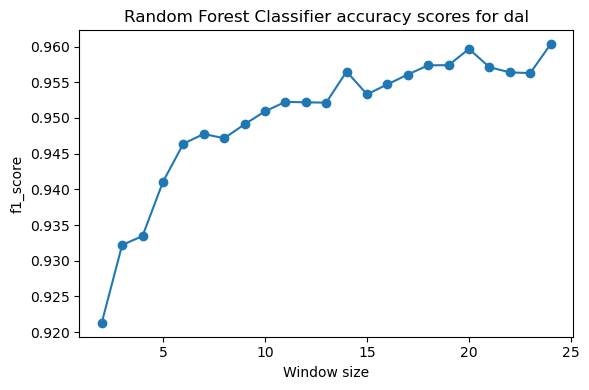

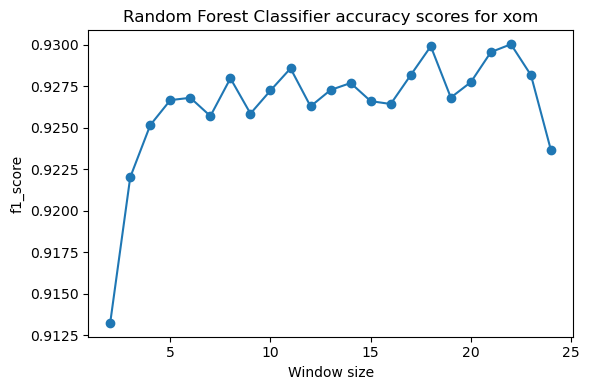

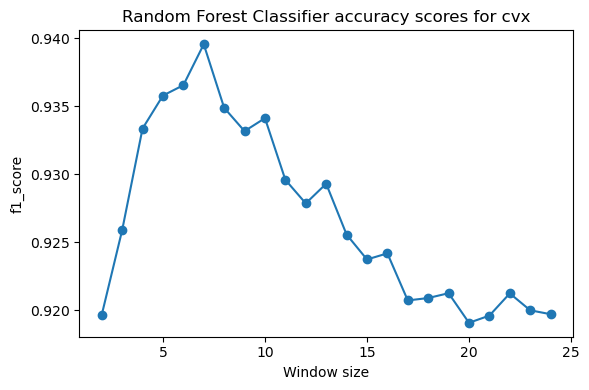

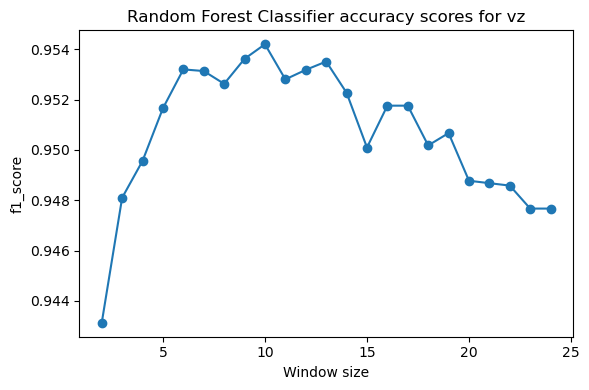

In [91]:
accuracies_rfc = {}
confusion_mat_rfc = {}
f1_score_rfc={}
#ada_model = AdaBoostClassifier(n_estimators=100,random_state=121)
for window in spread_range:
    accuracies_rfc[window] = {}
    confusion_mat_rfc[window] = {}
    f1_score_rfc[window]={}
    def helper(i):
        return accuracies_model(model_forest,window,i,map=False)
    pool=multiprocessing.Pool(len(stocks))
    results=list(pool.map(helper, range(len(stocks))))
    for stock_ind in range(len(stocks)):
        accuracies_rfc[window][stock_ind] = results[stock_ind][0]
        confusion_mat_rfc[window][stock_ind] = results[stock_ind][1]
        A=confusion_mat_rfc[window][stock_ind]
        f1_score_rfc[window][stock_ind]=(2*A[0][0]/(2*A[0][0]+A[0][1]+A[1][0]))
plot_accuracies(accuracies_rfc, "Random Forest Classifier")
plot_accuracies(f1_score_rfc,"Random Forest Classifier", acc_type='f1_score')